# Importing dependencies 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fast')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Loading csv file
df = pd.read_csv('data_science_job.csv')

# Chossing a style ( can see the list using the code : plt.style.available
plt.style.use('default')

# Introductory EDA

In [ ]:
# Checking the shape of the dataframe
df.shape

In [ ]:
# Checking any 5 random rows
df.sample(5)

In [ ]:
# Checking data type of the features
df.info()

In [ ]:
# Optimizing the memory by using appropriate data types
int_cols = df.select_dtypes(include=np.int64)
float_cols = df.select_dtypes(include=np.float64)

df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

In [ ]:
# Descriptive information about the data
df.describe()

In [ ]:
# Checking percentage of null values
df.isnull().mean()*100

In [ ]:
# Checking duplicated values
df.duplicated().sum()

In [ ]:
# Let's visualize distribution of the classes in the target variable
ex = (0,0.2)
df['target'].value_counts().plot(kind='pie',autopct='%.2f',explode= ex)

# Data Cleaning

In this step we will be handling the missing values,outliers and will also work on dealing with imbalanced data


In [ ]:
# Dropping the unnecessary columns from the dataframe
df = df.drop(['enrollee_id','city'],axis=1)
df.head(3)

In [ ]:
# Let's take out features having missing value percentage less than 5% 
cols_less5_per = [col for col in df.columns if df[col].isnull().mean()*100 <5 and df[col].isnull().mean()*100>0]


# Let's create 2 copy to compare the change in distribution
remove_nan = df[cols_less5_per].copy()
impute_nan = df[cols_less5_per].copy()

In [ ]:
# Dropping all the rows having column values as NaN
remove_nan.dropna(inplace=True)

Since city_development_index, experience and training hours are numerical features so we will use mean imputation, whereas for the remaining features we will do mode imputation.

In [ ]:
# Mean imputation
impute_nan['city_development_index'].fillna(df['city_development_index'].mean(),inplace=True)
impute_nan['experience'].fillna(df['city_development_index'].mean(),inplace=True)
impute_nan['training_hours'].fillna(df['city_development_index'].mean(),inplace=True)

# Mode imputation
impute_nan['enrolled_university'].fillna(impute_nan['enrolled_university'].mode().values[0],inplace=True)
impute_nan['education_level'].fillna(impute_nan['education_level'].mode().values[0],inplace=True)

In [ ]:
# Now let's visualize the distributions before and after implemnting CCA on numerical features
fig, ax = plt.subplots(1, 3, figsize=(17, 3.5))

sns.kdeplot(df['city_development_index'], fill=True,ax=ax[0], color='green', label='Origial')
sns.kdeplot(remove_nan['city_development_index'], fill=True,ax=ax[0], label='After removing')
sns.kdeplot(impute_nan['city_development_index'], fill=True,ax=ax[0], label='After imputation')
ax[0].legend(loc='upper center')
ax[0].set(title='Distribution comparision of City_development_index')

sns.kdeplot(df['experience'], fill=True,ax=ax[1], color='blue', label='Original')
sns.kdeplot(remove_nan['experience'], fill=True,ax=ax[1], label='After removing')
sns.kdeplot(impute_nan['experience'], fill=True,ax=ax[1], label='After imputing')
ax[1].legend(loc='upper center')
ax[1].set(title='Distribution comparision of Experience feature')

sns.kdeplot(df['training_hours'], fill=True,ax=ax[2], color='red', label='Original')
sns.kdeplot(remove_nan['training_hours'], fill=True,ax=ax[2], label='After removing')
sns.kdeplot(impute_nan['training_hours'], fill=True,ax=ax[2], label='After imputation')
ax[2].legend(loc='upper center')
ax[2].set(title='Distribution comparision of training hours')

For the categorical columns we will check the ratio of categories before and after applying PCA

In [ ]:
# For the categorical features we will check the ratio of classes before and after implementing CCA
compare_eu = pd.concat([df['enrolled_university'].value_counts() / len(df),
                    remove_nan['enrolled_university'].value_counts() / len(remove_nan),
                    impute_nan['enrolled_university'].value_counts()/len(impute_nan)],axis=1)

compare_eu.columns = ['Original','After removing','After imputation']
compare_eu

In [ ]:
compare_edu_level = pd.concat([ df['education_level'].value_counts() / len(df),
                        remove_nan['education_level'].value_counts() / len(remove_nan),
                        impute_nan['education_level'].value_counts()/len(impute_nan)],axis=1)

compare_edu_level.columns = ['Original','After removing','After imputation']
compare_edu_level

Let's now impute and remove missing values based the above analysis.

In [ ]:
# Dropping missing values in original dataframe
df.dropna(subset = ['city_development_index'],inplace=True)

# Mean value imputation in original dataframe
df['experience'].fillna(df['city_development_index'].mean(),inplace=True)
df['training_hours'].fillna(df['city_development_index'].mean(),inplace=True)

# Mode value imputation in original dataframe
df['enrolled_university'].fillna(df['enrolled_university'].mode().values[0],inplace=True)
df['education_level'].fillna(df['education_level'].mode().values[0],inplace=True)

Before dealing with features having missing value more than 5% let's first visualize the distribution of city_development_index and training_hours to decide which method to use for the detection and removal of outliers. 

## Detection and removal of outliers

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,3.5))

sns.kdeplot(df['training_hours'],shade=True,ax = ax[0])
ax[0].set(title='Distribution of training_hours')
ax[0].axvline(df['training_hours'].mean(),label = 'mean',color = 'red')
ax[0].axvline(df['training_hours'].median(),label = 'median',color = 'blue')
ax[0].axvline(df['training_hours'].mode().values[0],label = 'mode',color = 'green')
ax[0].legend()

sns.kdeplot(df['city_development_index'],shade=True,ax = ax[1])
ax[1].set(title='Distribution of city development index ')
ax[1].axvline(df['city_development_index'].mean(),label = 'mean',color = 'red')
ax[1].axvline(df['city_development_index'].median(),label = 'median',color = 'blue')
ax[1].axvline(df['city_development_index'].mode().values[0],label = 'mode',color = 'green')
ax[1].legend()

From the distributions we can clearly see that both the features are skewed. Training_hours feature is right skewed whereas city_development_index feature is left skewed. So we will use IQR method to detect outliers and handle outliers.

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots(1, 2, figsize=(18, 3))

# Let's visualize the outliers using the boxplots
sns.boxplot(x = df['city_development_index'],ax = ax[0]).set(title='Boxplot of city develoment index feature')
sns.boxplot(x = df['training_hours'],ax = ax[1]).set(title='Boxplot of training hours feature')

# Show the plot
plt.show()

Before removing or capping outliers let's create a copy of these features so that after either removing or capping outliers we could visualize the change in the distribution.

In [ ]:
remove_outliers = df[['city_development_index','training_hours']].copy()
cap_outliers = df[['city_development_index','training_hours']].copy()

In [ ]:
# Let's create a function for finding Uppper and lower limit
def find_limits(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    IQR = q3-q1
    Upper_lmt = q3 + 1.5*IQR
    Lower_lmt = q1 - 1.5*IQR
    return [Upper_lmt,Lower_lmt]

In [ ]:
# Calling the function to find the limits
lmts_city_dev_index = find_limits(remove_outliers['city_development_index'])
lmts_trainng_hrs = find_limits(remove_outliers['training_hours'])

In [ ]:
# Let's first cap the outliers
cap_outliers['city_development_index'] = np.where(
                                            cap_outliers['city_development_index']>lmts_city_dev_index[0],lmts_city_dev_index[0],
                                            np.where(cap_outliers['city_development_index']<lmts_city_dev_index[1],lmts_city_dev_index[1],
                                            cap_outliers['city_development_index']))
    
cap_outliers['training_hours'] = np.where(
                                            cap_outliers['training_hours']>lmts_trainng_hrs[0],lmts_trainng_hrs[0],
                                            np.where(cap_outliers['training_hours']<lmts_trainng_hrs[1],lmts_trainng_hrs[1],
                                            cap_outliers['training_hours']))

In [ ]:
# Let's now remove the outliers
remove_outliers['city_development_index'] = remove_outliers['city_development_index'][remove_outliers['city_development_index'] > lmts_city_dev_index[1]]
remove_outliers['training_hours'] = remove_outliers['training_hours'][remove_outliers['training_hours'] < lmts_trainng_hrs[0]]

In [ ]:
# Now lets visualize the change in the distribution before and after capping the outliers
fig,ax = plt.subplots(1,2,figsize = (14,3.5))

sns.kdeplot(df['city_development_index'],fill=True,color='red',label='Original',ax = ax[0]).legend(loc='upper center')
sns.kdeplot(remove_outliers['city_development_index'],fill=True,color='green',label='After removal',ax = ax[0]).legend(loc='upper center')
sns.kdeplot(cap_outliers['city_development_index'],fill=True,color='blue',label='After capping',ax = ax[0]).legend(loc='upper center')

sns.kdeplot(df['training_hours'],fill=True,color='red',label='Original',ax = ax[1]).legend(loc='upper center')
sns.kdeplot(remove_outliers['training_hours'],fill=True,color='green',label='After removal',ax = ax[1]).legend(loc='upper center')
sns.kdeplot(cap_outliers['training_hours'],fill=True,color='blue',label='After capping',ax = ax[1]).legend(loc='upper center')

In training_hours feature becasue of presence of a lot of outliers the distribution is chaning a lot after capping so we will move on with removing the outliers, whereas in city_development_index there is no significant change in distributuion even after removing or capping outliers so we will move on with capping the outliers.

In [ ]:
# Let's cap outiers in city_development_index of original dataframe
df['city_development_index'] = np.where(
                                        df['city_development_index']>lmts_city_dev_index[0],lmts_city_dev_index[0],
                                        np.where(df['city_development_index']<lmts_city_dev_index[1],lmts_city_dev_index[1],
                                        df['city_development_index'])
                                        )

In [ ]:
# Let's remove outliers in training_hours feature of original dataframe
df = df[df['training_hours'] < lmts_trainng_hrs[0]]

In [ ]:
sns.boxplot(x = df['training_hours'])

## Imputing missing values using MICE

In [ ]:
# Let's take all those features in which percentage of missing value is more than 5%
cols_more5_per = [cols for cols in df.columns if df[cols].isnull().mean()*100 >5]
Temp_df = df[cols_more5_per].copy()

In [ ]:
# Let's do the mode imputation
for cols in Temp_df.columns:
    Temp_df[cols].fillna(Temp_df[cols].mode()[0],inplace=True)

In [ ]:
# Create a dataframe to compare the original and imputed values of 'gender'
compare_gender = pd.concat([df['gender'].value_counts(normalize=True), Temp_df['gender'].value_counts(normalize=True)], axis=1)
compare_gender.columns = ['Original', 'After Imputation']
compare_gender

The ratio of categorical values is changin but for now just to keep gonig we will do mode imputation

In [ ]:
# Mode imputtion in the original dataframe
for cols in Temp_df.columns:
    df[cols].fillna(df[cols].mode()[0],inplace=True)

# Understanding data through visualizations

1. Does individuals with relevent experience gets more job ?
2. Does the individuals with full time enrollment gets more job than part time enrollment or no enrollment at all?
3. Individuals with which education level get most jobs ?
4. Does individuals with STEM backgroun get more jobs?
5. In which company size inidividuals gets more jobs ?
6. Which type of company hires the most ?

In [ ]:
# Let's create subplots
fig,ax = plt.subplots(3,2 ,figsize = (17,16))

temp1 = df.groupby('relevent_experience')['target'].sum()
temp2 = df.groupby('enrolled_university')['target'].sum()
temp3 = df.groupby('education_level')['target'].sum()
temp4 = df.groupby('major_discipline')['target'].sum()
temp5 = df.groupby('company_size')['target'].sum()
temp6 = df.groupby('company_type')['target'].sum()

sns.barplot(x = temp1.index,y = temp1,ax = ax[0][0],saturation=2).set(title='Relevent experience Vs Number of jobs')
sns.barplot(x = temp2.index,y = temp2,ax = ax[0][1],saturation=2).set(title='Univesity enrollment Vs Number of jobs')
sns.barplot(x = temp3.index,y = temp3,ax = ax[1][0],saturation=2).set(title='Education level Vs Number of jobs')
sns.barplot(x = temp4.index,y = temp4,ax = ax[1][1],saturation=2).set(title='Major discipline Vs Number of jobs')
sns.barplot(x = temp5.index,y = temp5,ax = ax[2][0],saturation=2).set(title='Company Size Vs Number of jobs')
sns.barplot(x = temp6.index,y = temp6,ax = ax[2][1],saturation=2).set(title='Company type Vs Number of jobs')

# Feature engineering

- Encode the categorical variables
- Feature scaling

In [ ]:
categorical_cols = df.select_dtypes(include='object')
categorical_cols.head(5)

Out of all the categorical columns : enrolled_university,company_size,relevent_experience and education level are ordinal categorical columns, rest all are nominal categorical columns.

In [ ]:
# Let's do ordinal encoding 
map_enrolled_uni = {'no_enrollment':1, 'Full time course':3, 'Part time course':2}
map_edu_level = {'Graduate':3, 'Masters':4, 'High School':2, 'Phd':5, 'Primary School':1}
map_exp = {'Has relevent experience':2,'No relevent experience':1}

df['enrolled_university'] = df['enrolled_university'].map(map_enrolled_uni)
df['education_level'] = df['education_level'].map(map_edu_level)
df['relevent_experience'] = df['education_level'].map(map_exp)

In [ ]:
fig,ax = plt.subplots(figsize=(25,12))
sns.heatmap(round(df.corr(numeric_only=True),2), annot=True, cmap='Blues')

In [ ]:
# Reducing number of features


In [ ]:
# One hot encoding 
pd.get_dummies(df,columns = ['gender'],drop_first=True)

In [51]:
# Let's create an object of MinMax scaler
scaler = MinMaxScaler()

In [52]:
y = new_df['target']
X = new_df.drop(['target'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42,stratify=y) 

In [53]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model training 

In [63]:
X_train = pd.DataFrame(X_train)
X_train.columns = ['Has relevent experience', 'STEM', 'NGO', 'Public Sector', 'Pvt Ltd',
       'city_development_index', 'experience', 'training_hours',
       'Enrolled_Uni', 'higher_edu', 'small_comp', 'medium_comp', 'large_comp',
       'Startup']

In [64]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [65]:
y_pred  =  model.predict(X_test)

C:\Users\YUVRAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [71]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

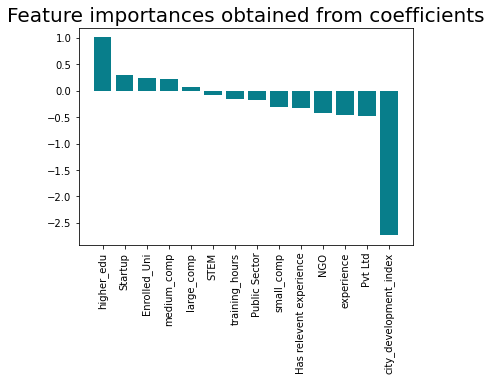

In [72]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [54]:
# Let's create an object of GaussianNB class
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [55]:
y_pred  =  classifier.predict(X_test)

In [56]:
# Now let's train the model and make predictions
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [57]:
y_pred = np.around(y_pred)
y_pred = y_pred.astype(np.int32)

# Model evaluation

In [69]:
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculating precision
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

# Calculating recall
recall = recall_score(y_test, y_pred, average='macro')
print("Recall: ", recall)

# Calculating F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score: ", f1)

Accuracy:  0.7693501454898157
Precision:  0.6851267244214739
Recall:  0.6030378024193548
F1 Score:  0.6143691022908293


In [43]:
'''Resulst with NB
Accuracy:  0.7668283220174588
Precision:  0.6805685519692035
Recall:  0.5922046370967742
F1 Score:  0.6007120579441181
''' 

'Resulst with NB\nAccuracy:  0.7668283220174588\nPrecision:  0.6805685519692035\nRecall:  0.5922046370967742\nF1 Score:  0.6007120579441181\n'